In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import os
from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [3]:
import sys
sys.path.append('../insight')
from archive import archive 
from insight_arch import Photoz_network
from insight import Insight_module
from utils import sigma68, nmad, plot_photoz_estimates
from scipy import stats
from scipy.stats import norm


In [4]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"
parent_dir = '/data/astro/scratch/lcabayol/Euclid/NNphotozs/Euclid_EXT_MER_PHZ_DC2_v1.5'

In [5]:
from torch import nn, optim
import torch
class Photoz_network(nn.Module):
    def __init__(self, num_gauss=10, dropout_prob=0, use_flag=False):
        super(Photoz_network, self).__init__()

        self.use_flag=use_flag
        self.features = nn.Sequential(
            nn.Linear(6, 10),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(10, 20),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(20, 50),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(20, 10)
        )
        
        self.measure_mu = nn.Sequential(
            nn.Linear(10, 20),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(20, num_gauss)
        )

        self.measure_coeffs = nn.Sequential(
            nn.Linear(10, 20),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(20, num_gauss)
        )

        self.measure_sigma = nn.Sequential(
            nn.Linear(10, 20),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(20, num_gauss)
        )
        
        self.flag_layer = nn.Sequential(
            nn.Linear(10, 20),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(20, 30),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(20, 1),
            
            
            nn.Sigmoid()
        )
        
    def forward(self, x):
        f = self.features(x)
        mu = self.measure_mu(f)
        sigma = self.measure_sigma(f)
        logmix_coeff = self.measure_coeffs(f)
        flag =  self.flag_layer(f)
        
        flag = torch.clamp(flag,0.01,0.99)
        
        logmix_coeff = logmix_coeff - torch.logsumexp(logmix_coeff, 1)[:,None]
        
        if self.use_flag:
            return mu, sigma, logmix_coeff, flag
        else: 
            return mu, sigma, logmix_coeff
            
    



In [6]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
from astropy.io import fits
import os
from astropy.table import Table
from scipy.spatial import KDTree
from scipy.special import erf

class Insight_module():
    """ Define class"""
    
    def __init__(self, model, batch_size=100,model_noise=False,rejection_param=1):
        self.model=model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.batch_size=batch_size
        self.model_noise=model_noise
        self.rejection_parameter=rejection_param
        
        
        if model_noise == True:
            self.noise_model = noise_model()
            
            
    def _get_dataloaders(self, input_data, target_data, additional_data=None, val_fraction=0.1):
        input_data = torch.Tensor(input_data)
        target_data = torch.Tensor(target_data)
        
        if additional_data is None:
            dataset = TensorDataset(input_data, target_data)
        else:
            additional_data = torch.Tensor(additional_data)
            dataset = TensorDataset(input_data, target_data,additional_data)
                    

        trainig_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*(1-val_fraction)), int(len(dataset)*val_fraction)+1])
        loader_train = DataLoader(trainig_dataset, batch_size=self.batch_size, shuffle = True)
        loader_val = DataLoader(val_dataset, batch_size=64, shuffle = True)

        return loader_train, loader_val

                


    def _loss_function(self,mean, std, logmix, true, flag=None):
                        
        if flag == None:   
            log_prob =   logmix - 0.5*(mean - true[:,None]).pow(2) / std.pow(2) - torch.log(std) 
            log_prob = torch.logsumexp(log_prob, 1)
            loss = -log_prob.mean()
            
        else:
            log_prob =   logmix - 0.5*(mean - true[:,None]).pow(2) / std.pow(2) - torch.log(std) 
            log_prob = torch.logsumexp(log_prob, 1)
            
            loss = log_prob + torch.log(flag).squeeze(1) 
            loss = -loss.mean()  + (self.rejection_parameter * flag).mean()

        return loss     

    def _to_numpy(self,x):
        return x.detach().cpu().numpy()
    
    
    def train_noise(self,input_data, target_data, noise_condition, nepochs=10, step_size = 100, val_fraction=0.1, lr=1e-3, lr_noise=1e-3 ):
        self.model = self.model.train()
        self.noise_model = self.noise_model.train()

        loader_train, loader_val = self._get_dataloaders(input_data, target_data, additional_data=noise_condition, val_fraction=0.1)
        optimizer_z = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler_z = torch.optim.lr_scheduler.StepLR(optimizer_z, step_size=step_size, gamma =0.1)
        
        
        optimizer_noise = optim.Adam(self.noise_model.parameters(), lr=lr_noise, weight_decay=1e-4)
        
        self.model = self.model.to(self.device)
        self.model_noise = self.noise_model.to(self.device)

        
        self.loss_train, self.loss_validation = [],[]
        

        for epoch in range(nepochs):
            self.error_coeffs = []
            self.noise_params=[]
            for input_data, target_data, noise_cond in loader_train:
                _loss_train, _loss_validation,  = [],[]

                input_data = input_data.to(self.device)
                target_data = target_data.to(self.device)
                noise_cond = noise_cond.to(self.device)
                                    
                
                optimizer_noise.zero_grad()
                optimizer_z.zero_grad()
                
                noise_param = self.model_noise(input_data,target_data )
                #print(noise_param.squeeze(1))
                hidden_label = torch.normal(mean=target_data, std=noise_param.squeeze(1))
                
            
                zlab_loss = -nn.MSELoss()(hidden_label, target_data)
                zlab_loss.backward()
                optimizer_noise.step()
                    
                    
                mu, logsig, logmix_coeff = self.model(input_data)
                logsig = torch.clamp(logsig,-6,2)
                sig = torch.exp(logsig)
                
                
                loss = self._loss_function(mu, sig, logmix_coeff,hidden_label.detach())
                _loss_train.append(loss.item())                
                
                loss.backward()
                optimizer_z.step()
                
                self.noise_params.append(noise_param.detach().cpu().numpy())
                            
            scheduler_z.step()   
                                

            self.loss_train.append(np.mean(_loss_train))

            for input_data, target_data, noise_cond in loader_val:


                input_data = input_data.to(self.device)
                target_data = target_data.to(self.device)


                mu, logsig, logmix_coeff = self.model(input_data)
                logsig = torch.clamp(logsig,-6,2)
                sig = torch.exp(logsig)

                loss_val = self._loss_function(mu, sig, logmix_coeff, target_data)
                _loss_validation.append(loss_val.item())

            self.loss_validation.append(np.mean(_loss_validation))

            print(f'training_loss:{loss}',f'testing_loss:{loss_val}')
           
    
        
    def train(self,input_data, target_data,  nepochs=10, step_size = 100, val_fraction=0.1, lr=1e-3 ):
        self.model = self.model.train()
        loader_train, loader_val = self._get_dataloaders(input_data, target_data, val_fraction=0.1)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma =0.1)
    
        
        self.model = self.model.to(self.device)
        
        self.loss_train, self.loss_validation = [],[]
        
        

        for epoch in range(nepochs):
            for input_data, target_data in loader_train:
                _loss_train, _loss_validation = [],[]

                input_data = input_data.to(self.device)
                target_data = target_data.to(self.device)


                optimizer.zero_grad()

                mu, logsig, logmix_coeff = self.model(input_data)
                logsig = torch.clamp(logsig,-6,2)
                sig = torch.exp(logsig)


                #print(mu,sig,target_data,torch.exp(logmix_coeff))

                loss = self._loss_function(mu, sig, logmix_coeff, target_data)
                _loss_train.append(loss.item())
                
                loss.backward()
                optimizer.step()
            
            scheduler.step()   
                                
            self.loss_train.append(np.mean(_loss_train))

            for input_data, target_data in loader_val:


                input_data = input_data.to(self.device)
                target_data = target_data.to(self.device)


                mu, logsig, logmix_coeff = self.model(input_data)
                logsig = torch.clamp(logsig,-6,2)
                sig = torch.exp(logsig)

                loss_val = self._loss_function(mu, sig, logmix_coeff, target_data)
                _loss_validation.append(loss_val.item())

            self.loss_validation.append(np.mean(_loss_validation))

            print(f'training_loss:{loss}',f'testing_loss:{loss_val}')
           
        
        
    def train_flag(self,input_data, target_data,  nepochs=10, step_size = 100, val_fraction=0.1, lr=1e-3 ):
        self.model = self.model.train()
        loader_train, loader_val = self._get_dataloaders(input_data, target_data, val_fraction=0.1)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma =0.1)
    
        
        self.model = self.model.to(self.device)
        
        self.loss_train, self.loss_validation = [],[]
        
        

        for epoch in range(nepochs):
            for input_data, target_data in loader_train:
                _loss_train, _loss_validation = [],[]

                input_data = input_data.to(self.device)
                target_data = target_data.to(self.device)


                optimizer.zero_grad()

                mu, logsig, logmix_coeff, useflag = self.model(input_data)
                logsig = torch.clamp(logsig,-6,2)
                sig = torch.exp(logsig)



                loss = self._loss_function(mu, sig, logmix_coeff, target_data,useflag)
                _loss_train.append(loss.item())
                
                loss.backward()
                optimizer.step()
            
            scheduler.step()   
                                
            self.loss_train.append(np.mean(_loss_train))

            for input_data, target_data in loader_val:


                input_data = input_data.to(self.device)
                target_data = target_data.to(self.device)


                mu, logsig, logmix_coeff, useflag = self.model(input_data)
                logsig = torch.clamp(logsig,-6,2)
                sig = torch.exp(logsig)

                loss_val = self._loss_function(mu, sig, logmix_coeff, target_data)
                _loss_validation.append(loss_val.item())

            self.loss_validation.append(np.mean(_loss_validation))

            print(f'training_loss:{loss}',f'testing_loss:{loss_val}')
           
        

        
    def get_pz(self,input_data, target_data, return_pz=False):
        self.model = self.model.eval()
        self.model = self.model.to(self.device)

        input_data = input_data.to(self.device)
        target_data = target_data.to(self.device)
                

        
        mu, logsig, logmix_coeff = self.model(input_data)
        logsig = torch.clamp(logsig,-6,2)
        sig = torch.exp(logsig)

        mix_coeff = torch.exp(logmix_coeff)

        z = (mix_coeff * mu).sum(1)
        zerr = torch.sqrt( (mix_coeff * sig**2).sum(1) + (mix_coeff * (mu - target_data[:,None])**2).sum(1))

        mu,  mix_coeff, sig = mu.detach().cpu().numpy(),  mix_coeff.detach().cpu().numpy(), sig.detach().cpu().numpy()  
        
        
        if return_pz==True:
            x = np.linspace(0, 4, 1000)
            pdf_mixture = np.zeros(shape=(len(target_data), len(x)))
            for ii in range(len(input_data)):
                for i in range(6):
                    pdf_mixture[ii] += mix_coeff[ii,i] * norm.pdf(x, mu[ii,i], sig[ii,i])

            return self._to_numpy(z),self._to_numpy(zerr), pdf_mixture#, self._to_numpy(useflag)
    
        else:
            return self._to_numpy(z),self._to_numpy(zerr)#, self._to_numpy(useflag)
        
    def pit(self, input_data, target_data):
        
        pit_list = []
        
        self.model = self.model.eval()
        self.model = self.model.to(self.device)

        input_data = input_data.to(self.device)
                

        mu, logsig, logmix_coeff, useflag = self.model(input_data)
        logsig = torch.clamp(logsig,-6,2)
        sig = torch.exp(logsig)

        mix_coeff = torch.exp(logmix_coeff)
        
        mu,  mix_coeff, sig = mu.detach().cpu().numpy(),  mix_coeff.detach().cpu().numpy(), sig.detach().cpu().numpy() 
        
        for ii in range(len(input_data)):
            pit = (mix_coeff[ii] * norm.cdf(target_data[ii]*np.ones(mu[ii].shape),mu[ii], sig[ii])).sum()
            pit_list.append(pit)
        
        
        return pit_list
    
    def crps(self, input_data, target_data):

        def measure_crps(cdf, t):
            zgrid = np.linspace(0,4,1000)
            Deltaz = zgrid[None,:] - t[:,None]
            DeltaZ_heaviside = np.where(Deltaz < 0,0,1)
            integral = (cdf-DeltaZ_heaviside)**2
            crps_value = integral.sum(1) / 1000

            return crps_value


        crps_list = []

        self.model = self.model.eval()
        self.model = self.model.to(insight.device)

        input_data = input_data.to(self.device)


        mu, logsig, logmix_coeff = self.model(input_data)
        logsig = torch.clamp(logsig,-6,2)
        sig = torch.exp(logsig)

        mix_coeff = torch.exp(logmix_coeff)


        mu,  mix_coeff, sig, useflag = mu.detach().cpu().numpy(),  mix_coeff.detach().cpu().numpy(), sig.detach().cpu().numpy() 

        z = (mix_coeff * mu).sum(1)

        x = np.linspace(0, 4, 1000)
        pdf_mixture = np.zeros(shape=(len(target_data), len(x)))
        for ii in range(len(input_data)):
            for i in range(6):
                pdf_mixture[ii] += mix_coeff[ii,i] * norm.pdf(x, mu[ii,i], sig[ii,i])

        pdf_mixture = pdf_mixture / pdf_mixture.sum(1)[:,None]


        cdf_mixture = np.cumsum(pdf_mixture,1)

        crps_value = measure_crps(cdf_mixture, target_data)



        return crps_value
            

    def plot_photoz(self, df, nbins,xvariable,metric, type_bin='bin'):
        bin_edges = stats.mstats.mquantiles(df[xvariable].values, np.linspace(0.1,1,nbins))
        ydata,xlab = [],[]


        for k in range(len(bin_edges)-1):
            edge_min = bin_edges[k]
            edge_max = bin_edges[k+1]

            mean_mag =  (edge_max + edge_min) / 2

            if type_bin=='bin':
                df_plot = df_test[(df_test.imag > edge_min) & (df_test.imag < edge_max)]
            elif type_bin=='cum':
                df_plot = df_test[(df_test.imag < edge_max)]
            else:
                raise ValueError("Only type_bin=='bin' for binned and 'cum' for cumulative are supported")


            xlab.append(mean_mag)
            if metric=='sig68':
                ydata.append(sigma68(df_plot.zwerr))
            elif metric=='bias':
                ydata.append(np.mean(df_plot.zwerr))
            elif metric=='nmad':
                ydata.append(nmad(df_plot.zwerr))
            elif metric=='outliers':
                ydata.append(len(df_plot[np.abs(df_plot.zwerr)>0.15])/len(df_plot))

        plt.plot(xlab,ydata, ls = '-', marker = '.', color = 'navy',lw = 1, label = '')
        plt.ylabel(f'{metric}$[\Delta z]$', fontsize = 18)
        plt.xlabel(f'{xvariable}', fontsize = 16)

        plt.xticks(fontsize = 14)
        plt.yticks(fontsize = 14)

        plt.grid(False)

        plt.show()
   
        
    def plot_pz(self, m, pz, specz):
        # Create a figure and axis
        fig, ax = plt.subplots(figsize=(8, 6))

        # Plot the PDF with a label
        ax.plot(np.linspace(0, 4, 1000), pz[m], label='PDF', color='navy')

        # Add a vertical line for 'specz_test'
        ax.axvline(specz[m], color='black', linestyle='--', label=r'$z_{\rm s}$')

        # Add labels and a legend
        ax.set_xlabel(r'$z$', fontsize = 18)
        ax.set_ylabel('Probability Density', fontsize=16)
        ax.legend(fontsize = 18)

        # Display the plot
        plt.show()
    

In [7]:
photoz_archive = archive(path = parent_dir,only_zspec=True,flags_kept=[1. , 1.1, 1.4, 1.5, 2,2.1,2.4,2.5,3., 3.1, 3.4, 3.5,  4., 9. , 9.1, 9.3, 9.4, 9.5,11.1, 11.5, 12.1, 12.5, 13. , 13.1, 13.5, 14, ])
f, ferr, specz ,VIS_mag = photoz_archive.get_training_data()
f_test, ferr_test, specz_test ,VIS_mag_test = photoz_archive.get_testing_data()


In [8]:
nnz = Photoz_network(num_gauss=6,use_flag=False)
insight = Insight_module(nnz, batch_size=100, model_noise=False)
insight.train(input_data=f, 
              target_data=specz, 
              nepochs=300, 
              step_size = 150, 
              val_fraction=0.1, 
              lr=1e-3
             )

training_loss:-0.19010913372039795 testing_loss:0.13325932621955872
training_loss:-0.2535383403301239 testing_loss:-0.2454136461019516
training_loss:-0.19042308628559113 testing_loss:-0.23571482300758362
training_loss:-0.3953995704650879 testing_loss:-0.07508891075849533
training_loss:-0.2154330462217331 testing_loss:-0.007094168569892645
training_loss:-0.28887230157852173 testing_loss:-0.07994168251752853
training_loss:-0.5151026248931885 testing_loss:-0.5275366902351379
training_loss:-0.5476959347724915 testing_loss:0.0013427258236333728
training_loss:-0.5543616414070129 testing_loss:-0.21467804908752441
training_loss:-0.7158379554748535 testing_loss:-0.7650799751281738
training_loss:-0.651984691619873 testing_loss:-1.0938243865966797
training_loss:-0.760887861251831 testing_loss:-1.2315391302108765
training_loss:-0.8013896942138672 testing_loss:-1.3875235319137573
training_loss:-0.7565187215805054 testing_loss:-0.7385885119438171
training_loss:-0.8615131378173828 testing_loss:-0.818

In [18]:
z,zerr, pz = insight.get_pz(input_data=torch.Tensor(f_test), target_data=torch.Tensor(specz_test),return_pz=True)
df = pd.DataFrame(np.c_[VIS_mag_test, specz_test,z,zerr], columns = ['VISmag','zs','z','zuncert'])
df['zwerr'] = (df.z -df.zs) / (1+df.zs)



In [12]:
nmad(df.zwerr)

0.04924346710899313

In [19]:
zgrid = np.linspace(0, 4, 1000)

In [20]:
pz = pz / pz.sum(1)[:,None]

In [21]:
diff_matrix = np.abs(z[:,None] - zgrid[None,:])
idx = np.argmin(diff_matrix,1)


In [22]:
p_z_x = np.zeros(shape=(len(pz)))
for ii in range(len(pz)):
    p_z_x[ii] = pz[ii,idx[ii]]

In [23]:
df['p_z_x'] =p_z_x

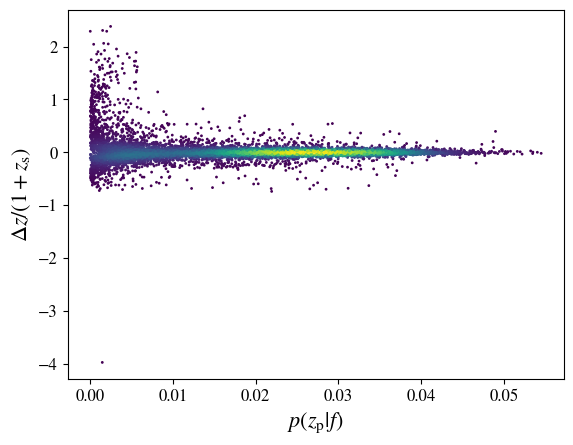

In [35]:
from scipy.stats import gaussian_kde
xy = np.vstack([df.p_z_x,df.zwerr])
c = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()

plt.scatter(df.p_z_x,df.zwerr, c=c,s=1)

plt.xlabel(r'$p(z_{\rm p}|f)$', fontsize=16)
plt.ylabel(r'$\Delta z / (1 + z_{\rm s})$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('FLAGvsERROR.pdf', bbox_inches='tight')

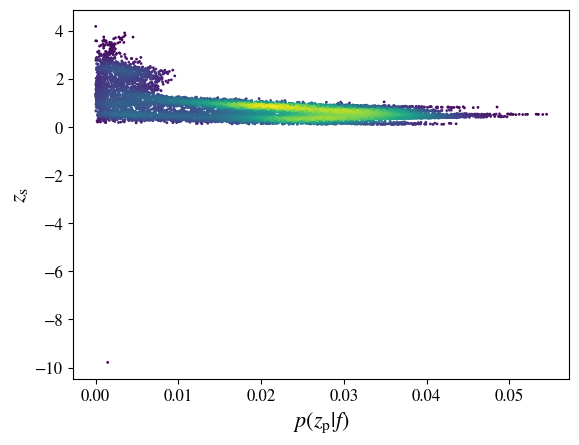

In [36]:
xy = np.vstack([df.p_z_x,df.z])
c = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()

plt.scatter(df.p_z_x,df.z, c=c,s=1)

plt.xlabel(r'$p(z_{\rm p}|f)$', fontsize=16)
plt.ylabel(r'$z_{\rm s}$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('FLAGvsz.pdf', bbox_inches='tight')

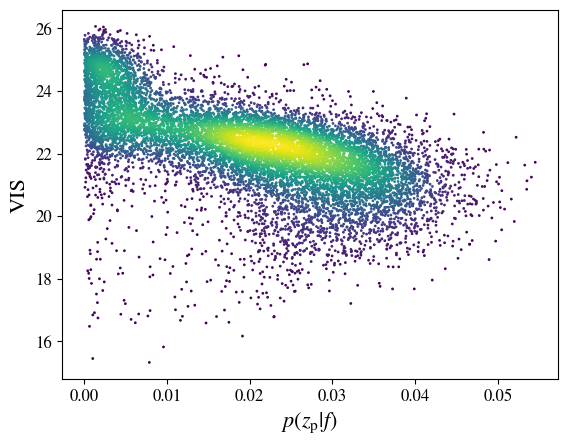

In [37]:
xy = np.vstack([df.p_z_x,df.VISmag])
c = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()

plt.scatter(df.p_z_x,df.VISmag, c=c,s=1)

plt.xlabel(r'$p(z_{\rm p}|f)$', fontsize=16)
plt.ylabel(r'VIS', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('FLAGvsVIS.pdf', bbox_inches='tight')

In [53]:
bin_edges = stats.mstats.mquantiles(df.p_z_x, np.arange(0,1.01,0.05))
scatter, eta,xlab = [],[],[]

for k in range(len(bin_edges)-1):
    edge_min = bin_edges[k]
    edge_max = bin_edges[k+1]
    
    
    
    df_bin = df[(df.p_z_x > edge_min)]    
    

    
    xlab.append(np.round(len(df_bin)/len(df),2)*100)
    scatter.append(nmad(df_bin.zwerr))
    eta.append(len(df_bin[np.abs(df_bin.zwerr)>0.15])/len(df)*100)



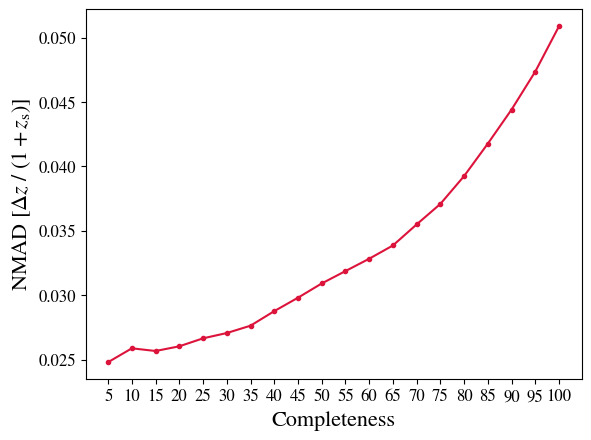

In [57]:
plt.plot(xlab,scatter, marker = '.', color ='crimson')


plt.ylabel(r'NMAD [$\Delta z\ /\ (1 + z_{\rm s})$]', fontsize=16)
plt.xlabel('Completeness', fontsize=16)

plt.yticks(fontsize=12)
plt.xticks(np.arange(5,101,5), fontsize=12)
plt.savefig('FLAG_NMAD.pdf', bbox_inches='tight')
plt.show()

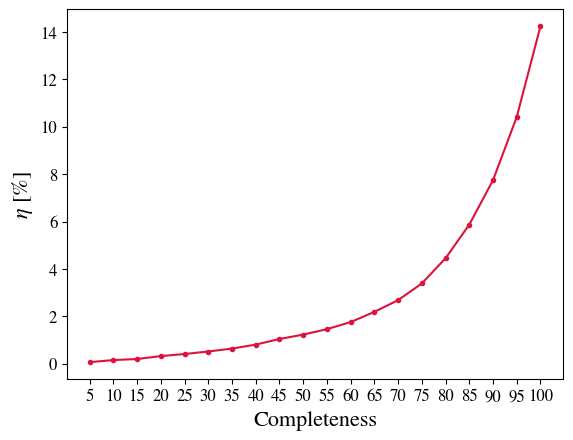

In [58]:
plt.plot(xlab,eta, marker='.', color ='crimson')
plt.yticks(fontsize=12)
plt.xticks(np.arange(5,101,5), fontsize=12)
plt.ylabel(r'$\eta$ [%]', fontsize=16)
plt.xlabel('Completeness', fontsize=16)
plt.savefig('FLAG_outliers.pdf', bbox_inches='tight')

plt.show()